In [50]:
import pandas as pd
import numpy as np
import os
import datetime
from datetime import date
#from datetime import datetime


In [51]:
# setting saving directory
today = date.today()
now = datetime.datetime.now()
print (today)
print (now)
dt_string = now.strftime("%d-%m-%Y_%H-%M-%S") #do not put : or similar 
print("date and time =", dt_string)	    
root = "C:/Users/arita/Documents/private/Data Engineering/2semestre/Stochastic_modeling/Project/data/outputs"

#saving function
def saveAsCSV(df,name,rootdir = root):
    """
    df = dataframe
    name = name for saving in format: 'thisisthename.csv'
    rootdir = local saving directory, default is root
    """
    savepath = root +'/' + dt_string+'_'+ name 
    df.to_csv ( savepath, index = False, header=True)

2020-06-21
2020-06-21 11:14:42.581278
date and time = 21-06-2020_11-14-42


In [52]:
#eg of usage
#saveAsCSV(df_adult1,'df_adult1.csv')

In [53]:
## Get address of where the repository is located on your computer.

# Will raise exception is you're in the wrong folder.
if not os.getcwd().endswith("02443-SimSolarEnergy\\code"):
    raise Exception("Change working directory to the code folder.")
repo_loc = os.getcwd()[ : -len("\\code")]


In [54]:
# Load data
activ = pd.read_csv(repo_loc + "\\data\\UK-TUS-15-0616\\activity.csv")
house = pd.read_csv(repo_loc + "\\data\\UK-TUS-15-0616\\household.csv")
indiv = pd.read_csv(repo_loc + "\\data\\UK-TUS-15-0616\\individual.csv")

for data in [activ, house, indiv]:
    print(data.head())
    print("\n\n")

     serial  pnum               t_start  eptime  whatdoing_exact  WhereWhen  \
0  11011202     1  2014-12-11T03:00:00Z     110              110         11   
1  11011202     1  2014-12-11T04:50:00Z      10             8219         11   
2  11011202     1  2014-12-11T05:00:00Z      10              310         11   
3  11011202     1  2014-12-11T05:10:00Z      10             3210         11   
4  11011202     1  2014-12-11T05:20:00Z      10             3110         11   

   whatdoing  
0          0  
1          8  
2          0  
3          3  
4          3  



     serial  num_adult  num_child  num_room  microwav  dishwash  dhhtype
0  11010903          2          0         8      True      True      3.0
1  11010904          2          0         6     False      True      3.0
2  11010906          3          0         4      True     False      7.0
3  11010907          2          1         3      True     False      2.0
4  11010908          1          0         6      True      True    

In [55]:
# Check for nulls
activ.isna().any()

serial             False
pnum               False
t_start             True
eptime             False
whatdoing_exact    False
WhereWhen          False
whatdoing          False
dtype: bool

In [56]:
# What proportion of time values are null?
len(activ[activ.t_start.isna()])/len(activ)

0.0035107005745092165

In [57]:
# Not many out of the total, so let's just delete them
activ = activ[activ.t_start.isna() == False]

In [58]:
activ.head(10)

,serial,pnum,t_start,eptime,whatdoing_exact,WhereWhen,whatdoing
0,11011202,1,2014-12-11T03:00:00Z,110,110,11,0
1,11011202,1,2014-12-11T04:50:00Z,10,8219,11,8
2,11011202,1,2014-12-11T05:00:00Z,10,310,11,0
3,11011202,1,2014-12-11T05:10:00Z,10,3210,11,3
4,11011202,1,2014-12-11T05:20:00Z,10,3110,11,3
5,11011202,1,2014-12-11T05:30:00Z,10,7241,11,7
6,11011202,1,2014-12-11T05:40:00Z,10,210,11,0
7,11011202,1,2014-12-11T05:50:00Z,10,3819,11,3
8,11011202,1,2014-12-11T06:00:00Z,30,210,11,0
9,11011202,1,2014-12-11T06:30:00Z,10,3310,11,3


In [59]:
# Only take from one year
#activ = activ[activ.t_start.str.startswith("2015")]

In [60]:
# First of all, only take the 11's
#activ = activ[activ.WhereWhen == 11]

In [61]:
#need to convert date time formatting and split it 
def convertandsplitdatetime(df_test): 
    index = df_test.columns.get_loc("t_start")
    df_test['t_start'] = pd.to_datetime(df_test['t_start'], format='%Y-%m-%dT%H:%M:%SZ')
    new_date = [d.date() for d in df_test['t_start']]
    new_time = [d.time() for d in df_test['t_start']]
    #df_test = df_test.drop(columns = ['t_start'])
    df_test.insert (index, "Date", new_date)
    df_test.insert (index+1, "Time", new_time)
    return df_test

# need to duplicate rows and chenge their eptime
def getmultitimesteps_fixedlenght(df_test): 
    df_test.eptime = df_test.eptime.astype(float)
    df_test = df_test.loc[df_test.index.repeat((df_test.eptime/10).astype(int))]
    df_test.loc[df_test['eptime'] > 10, 'eptime' ] = 10
    #df_test.head(15)
    #df_test.shape
    return df_test


#creates new column with corrected Times for activities lasting longer than 10 min
# here i am checking one by one each line and comparing it with the previous over the "old index" which is the same for copied lines
def updatetimes(df_test):
    df_test = df_test.reset_index()
    df_test = df_test.rename(columns={"index": "old_time_index"})
    
    all_indexes = df_test.index.values.tolist()
    old_indexes =  df_test.old_time_index.values.tolist()
    #print (old_indexes)
    newSetOfTimes = [] # empty list
    newSetOfTimes.append(df_test['Time'][0])
    for idx in range(1,len(all_indexes)): #going through all the indexes
        #print (type(old_indexes[idx]),old_indexes[idx])
        if (old_indexes[idx] != old_indexes[idx -1]): #so its the first of new serie
        #if (old_indexes[idx][1] != old_indexes[idx -1][1] ): #so its the first of new serie
            #print ("different")
            element= df_test['Time'][idx] # accessing the exact row only!
            newSetOfTimes.append(element)
            #print (element)
        else:
            #print ("same")
            previous_element=newSetOfTimes[-1] #df_test['Time'][idx-1]
            deltaminutes =  datetime.timedelta(minutes =10)
            element = (datetime.datetime.combine(datetime.date(1,1,1),previous_element) + deltaminutes).time()
            newSetOfTimes.append(element)
            #print (element)
    
    #after iterating on ALL the  indexes we have all the updated times
    newSetOfTimes = pd.Series(newSetOfTimes, name = 'New_Time')
    new_column_df = newSetOfTimes.to_frame()    
    
    #we check for missing values, if the new column is shorter--> erron in the concatenation!
    if (len(all_indexes) != len(newSetOfTimes)):
        print("original len: %i, modified len: %i"  %(len(all_indexes) ,len(newSetOfTimes)))
        
    #concat on axis = 1 --> we add one column
    df_test = pd.concat([df_test, new_column_df],axis=1)
    
    return df_test

def createTimeStates (df_test):
    time_period = []
    for i in range((len(df_test .New_Time))):
        tp = (round(df_test.New_Time[i].minute / 10) + df_test.New_Time[i].hour * 6)
        #print(tp)
        time_period.append(tp)

    time_period = pd.Series(time_period, name = 'time_period')
    new_column_df = time_period.to_frame()    

    #concat on axis = 1 --> we add one column
    df_test = pd.concat([df_test, new_column_df],axis=1)
    return df_test

def addDayOfWeek(df_test):
    df_test['day_of_week'] = df_test['t_start'].dt.day_name()
    return df_test

def getSeason(date_time):
    #print (type(date_time))
    month = date_time.month
    season = [(month%12 + 3)//3]
    #print ((season[0]))
    if (season[0] == 1):
        season_verbose = 'winter'
    elif (season[0] == 2):
        season_verbose = 'spring'
    elif (season[0] == 3):
        season_verbose = 'summer'
    else:
        season_verbose = 'autumn'
    return season_verbose 
    #return season 

def addSeason(df_test):
    local = df_test.copy()
    local['Season']= local['t_start'].apply(getSeason)
    return local

def addUniquePersonID(dt_test):
    dt_test["person_id"] = dt_test["serial"] + dt_test["pnum"]/100
    return dt_test


In [62]:
def analysisOfTime(df_test):
    all_days= len(df_test.Date)
    unique_days = (df_test.Date.unique())
    print ("Serie starting on:%s ending on:%s"%(min(unique_days),max(unique_days)))
    print ("To be complete there should be %s "%( max(unique_days)-min(unique_days)))
    print ("In this serie %i unique days are recorded" %(len(unique_days)))


def df_initial_overview (df_test, i= 0):
    label = all_dataframes_labels[i]
    print ("")
    print ("Intial Overview of: %s"%label)
    print ("Shape of %s : %s"%(label, df_test.shape))
    #unique_people = len(df_test.pnum.unique())
    unique_hh = len(df_test.serial.unique())
    print ("Analized: %i households"%(unique_hh))
    #analysisOfTime(df_test)
    
def df_processing(df_test, i= 0):
    label = all_dataframes_labels[i]
  
    df_test = convertandsplitdatetime(df_test)
    analysisOfTime(df_test)
    df_test = addDayOfWeek(df_test)
    df_test = addSeason(df_test)
    df_test = addUniquePersonID(df_test)
    df_test = getmultitimesteps_fixedlenght(df_test)
    df_test = updatetimes(df_test)
    df_test = createTimeStates(df_test)
    
    dt_string = now.strftime("%d-%m-%Y_%H-%M-%S") #do not put : or similar 
    saveAsCSV(df_test,label+'.csv')
    return df_test
    
def df_final_overview (df_test, i= 0):
    label = all_dataframes_labels[i]
    print ("")
    print ("Final Overview %s"%label)
    print ("shape of %s : %s"%(label, df_test.shape))
    unique_people = len(df_test.person_id.unique())
    unique_hh = len(df_test.serial.unique())
    print ("Analized: %i households, and %i people "%(unique_hh,unique_people))
    analysisOfTime(df_test)
    #df_test.Season.hist(bins=4, alpha=0.5)
    subset = df_test[['person_id','sex','age','Date','Season','day_of_week','whatdoing_exact','New_Time','time_period']]
    print(subset.head(20))
    
def allparsing(df_test, i= 0):
    df_initial_overview(df_test,i)
    df_test = df_processing(df_test, i)
    df_final_overview(df_test,i)
    return df_test
    

In [63]:
#joining dataframe indiv and activ over customer serial and pnum
new_df = pd.merge(activ, indiv, how= 'left', left_on = ['serial','pnum'],right_on = ['serial','pnum'])

#new_df['whatdoing_exact'] =new_df['whatdoing_exact'].apply(keep2)
new_df = new_df.drop(columns = ['WhereWhen','whatdoing','deconact'])
new_df.head()

,serial,pnum,t_start,eptime,whatdoing_exact,sex,age
0,11011202,1,2014-12-11T03:00:00Z,110,110,2,48
1,11011202,1,2014-12-11T04:50:00Z,10,8219,2,48
2,11011202,1,2014-12-11T05:00:00Z,10,310,2,48
3,11011202,1,2014-12-11T05:10:00Z,10,3210,2,48
4,11011202,1,2014-12-11T05:20:00Z,10,3110,2,48


In [64]:
#checking min and max age
list_ages = new_df['age'].unique()
print (len(list_ages ))
print (max(list_ages), min(list_ages),np.mean(list_ages))


90
99 8 52.53333333333333


sex
1    AxesSubplot(0.125,0.125;0.775x0.755)
2    AxesSubplot(0.125,0.125;0.775x0.755)
Name: age, dtype: object

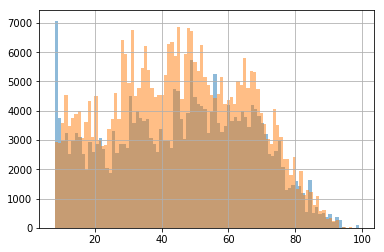

In [65]:
#plotting age distribution of age
#new_df.age.plot(kind='kde')
new_df.groupby('sex').age.hist(bins=len(list_ages), alpha=0.5)

In [66]:
#split the main dataframe in many 
df_child = new_df[(new_df['age']>=8) & (new_df['age']<18) ]
df_adult1 = new_df[(new_df['age']>=18) & (new_df['age']<30) ]
df_adult2 = new_df[(new_df['age']>=30) & (new_df['age']<45) ]
df_adult3 = new_df[(new_df['age']>=45) & (new_df['age']<60) ]
df_adult4 = new_df[(new_df['age']>=60) & (new_df['age']<75) ]
df_senior = new_df[(new_df['age']>=75)]

In [67]:
#append them all in one vector
all_dataframes = []
all_dataframes.append(df_child)
all_dataframes.append(df_adult1)
all_dataframes.append(df_adult2)
all_dataframes.append(df_adult3)
all_dataframes.append(df_adult4)
all_dataframes.append(df_senior)

In [68]:
#append all dataframes_labels in one vector
all_dataframes_labels = []
all_dataframes_labels.append('df_child')
all_dataframes_labels.append('df_adult1')
all_dataframes_labels.append('df_adult2')
all_dataframes_labels.append('df_adult3')
all_dataframes_labels.append('df_adult4')
all_dataframes_labels.append('df_senior')

In [69]:
for i in range(len(all_dataframes)):
    print ("shape of %s : %s"%(all_dataframes_labels[i], all_dataframes[i].shape))

shape of df_child : (67105, 7)
shape of df_adult1 : (79913, 7)
shape of df_adult2 : (131221, 7)
shape of df_adult3 : (141815, 7)
shape of df_adult4 : (119377, 7)
shape of df_senior : (46138, 7)


In [70]:
# aaand RUN!

for i in range(len(all_dataframes)):
    df_test = all_dataframes[i]
    allparsing(df_test,i)



Intial Overview of: df_child
Shape of df_child : (67105, 7)
Analized: 761 households


C:\Users\arita\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


Serie starting on:2014-04-04 ending on:2015-12-12
To be complete there should be 617 days, 0:00:00 
In this serie 480 unique days are recorded


C:\Users\arita\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



Final Overview df_child
shape of df_child : (323200, 15)
Analized: 761 households, and 1128 people 
Serie starting on:2014-04-04 ending on:2015-12-12
To be complete there should be 617 days, 0:00:00 
In this serie 480 unique days are recorded
      person_id  sex  age        Date  Season day_of_week  whatdoing_exact  \
0   11011202.04    1   13  2014-12-11  winter    Thursday              110   
1   11011202.04    1   13  2014-12-11  winter    Thursday              110   
2   11011202.04    1   13  2014-12-11  winter    Thursday              110   
3   11011202.04    1   13  2014-12-11  winter    Thursday              110   
4   11011202.04    1   13  2014-12-11  winter    Thursday              110   
5   11011202.04    1   13  2014-12-11  winter    Thursday              110   
6   11011202.04    1   13  2014-12-11  winter    Thursday              110   
7   11011202.04    1   13  2014-12-11  winter    Thursday              110   
8   11011202.04    1   13  2014-12-11  winter    Thurs

      person_id  sex  age        Date  Season day_of_week  whatdoing_exact  \
0   11011202.01    2   48  2014-12-11  winter    Thursday              110   
1   11011202.01    2   48  2014-12-11  winter    Thursday              110   
2   11011202.01    2   48  2014-12-11  winter    Thursday              110   
3   11011202.01    2   48  2014-12-11  winter    Thursday              110   
4   11011202.01    2   48  2014-12-11  winter    Thursday              110   
5   11011202.01    2   48  2014-12-11  winter    Thursday              110   
6   11011202.01    2   48  2014-12-11  winter    Thursday              110   
7   11011202.01    2   48  2014-12-11  winter    Thursday              110   
8   11011202.01    2   48  2014-12-11  winter    Thursday              110   
9   11011202.01    2   48  2014-12-11  winter    Thursday              110   
10  11011202.01    2   48  2014-12-11  winter    Thursday              110   
11  11011202.01    2   48  2014-12-11  winter    Thursday       